In [19]:
import os

print(os.listdir("/kaggle/input"))
print(os.listdir("/kaggle/input/dattaa"))
print(os.listdir("/kaggle/input/dattaa/datasetttt"))


['dattaa']
['datasetttt']
['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, ReLU, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical

np.random.seed(42)
tf.random.set_seed(42)

In [21]:
! kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset-v2

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


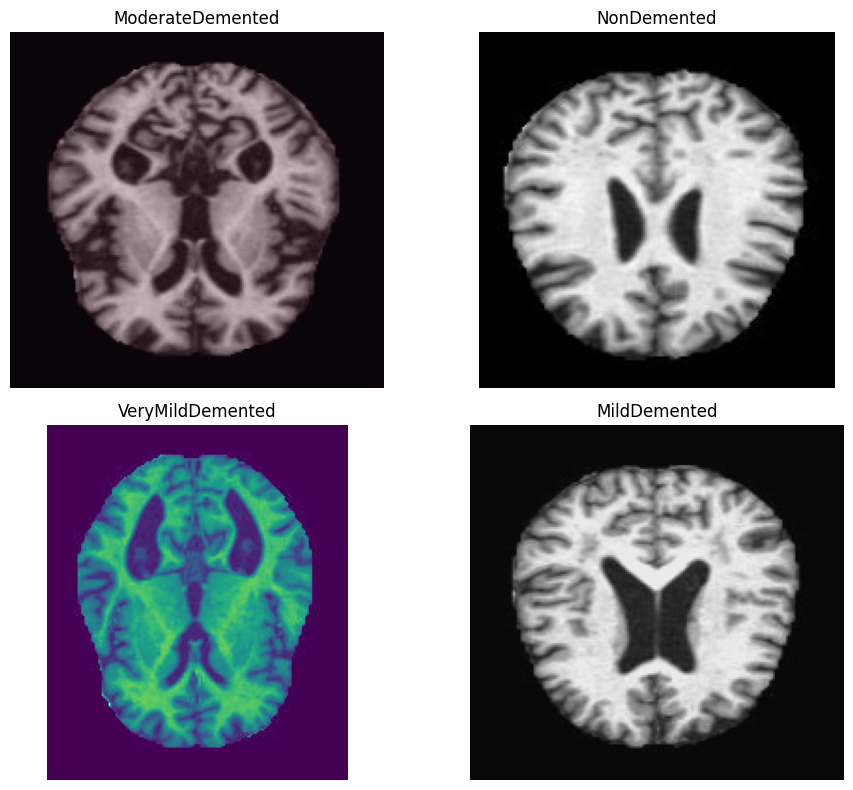

In [25]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

DATASET_PATH = "/kaggle/input/dattaa/datasetttt"
CLASSES = os.listdir(DATASET_PATH)

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(CLASSES):
    class_dir = os.path.join(DATASET_PATH, class_name)
    images = os.listdir(class_dir)
    
    img_name = random.choice(images)
    img_path = os.path.join(class_dir, img_name)
    
    img = Image.open(img_path)
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()


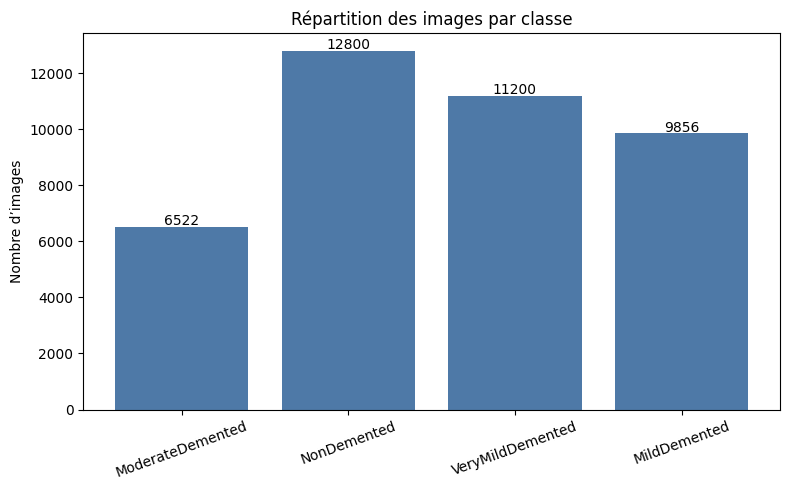

{'ModerateDemented': 6522,
 'NonDemented': 12800,
 'VeryMildDemented': 11200,
 'MildDemented': 9856}

In [26]:
class_counts = {}

for class_name in CLASSES:
    class_dir = os.path.join(DATASET_PATH, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color="#4E79A7")
plt.ylabel("Nombre d’images")
plt.title("Répartition des images par classe")
plt.xticks(rotation=20)

for i, v in enumerate(class_counts.values()):
    plt.text(i, v + 50, str(v), ha="center")

plt.tight_layout()
plt.savefig("histogramme.png", dpi=300)
plt.show()

class_counts


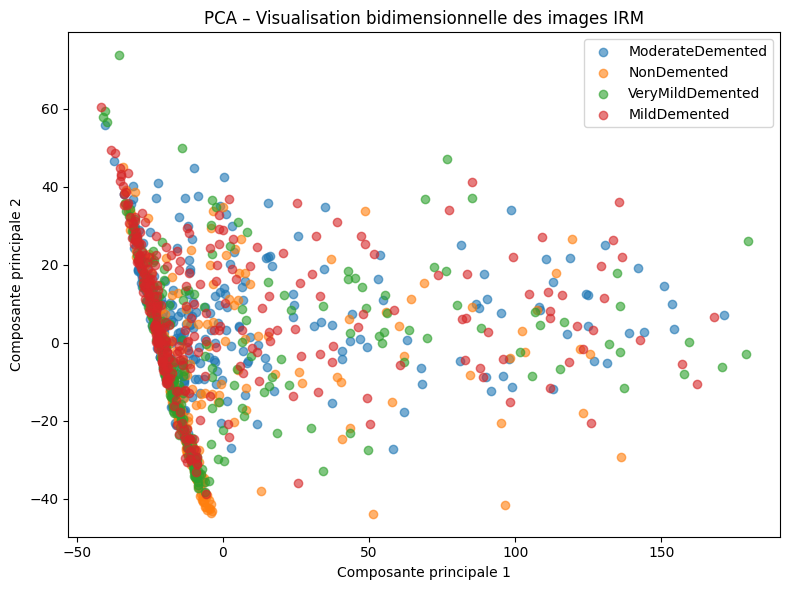

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = []
y = []

IMG_SIZE = 64  # réduit pour PCA

for label, class_name in enumerate(CLASSES):
    class_dir = os.path.join(DATASET_PATH, class_name)
    images = random.sample(os.listdir(class_dir), min(300, len(os.listdir(class_dir))))

    for img_name in images:
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img.flatten())
        y.append(label)

X = np.array(X)
y = np.array(y)

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(CLASSES):
    plt.scatter(
        X_pca[y == i, 0],
        X_pca[y == i, 1],
        label=class_name,
        alpha=0.6
    )

plt.legend()
plt.title("PCA – Visualisation bidimensionnelle des images IRM")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.tight_layout()
plt.savefig("pca.jpg", dpi=300)
plt.show()


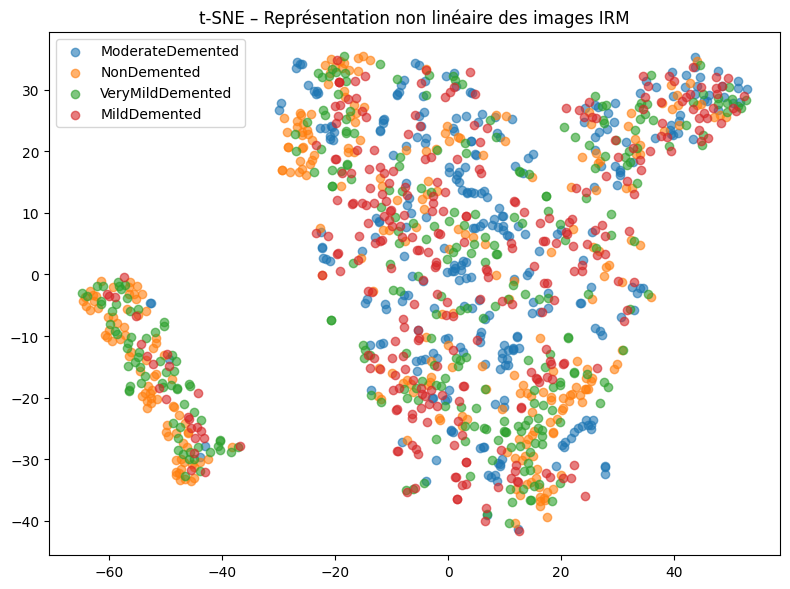

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(CLASSES):
    plt.scatter(
        X_tsne[y == i, 0],
        X_tsne[y == i, 1],
        label=class_name,
        alpha=0.6
    )

plt.legend()
plt.title("t-SNE – Représentation non linéaire des images IRM")
plt.tight_layout()
plt.savefig("t-sne.jpg", dpi=300)
plt.show()


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)


In [30]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [31]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 32303 images belonging to 4 classes.
Found 8075 images belonging to 4 classes.


In [32]:
train_generator.class_indices


{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

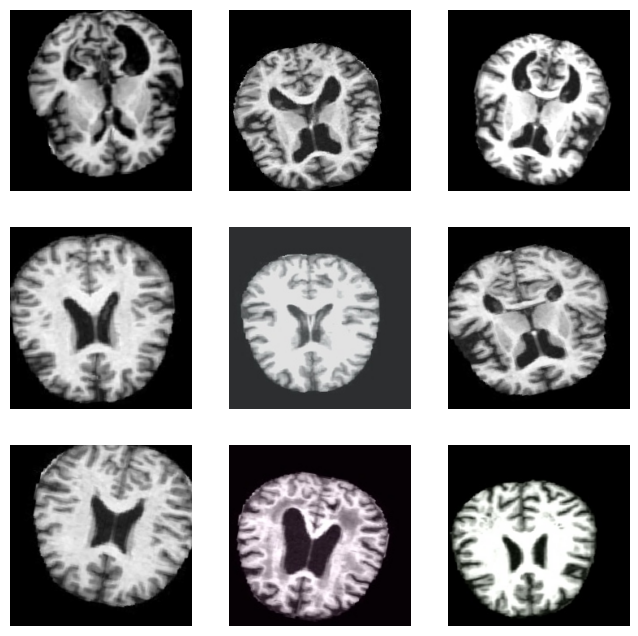

In [33]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()


In [38]:
import shutil
import os

SRC_PATH = "/kaggle/input/dattaa/datasetttt"
DST_PATH = "/kaggle/working/dataset_augmented"

shutil.copytree(SRC_PATH, DST_PATH)

print("Dataset copié vers :", DST_PATH)


Dataset copié vers : /kaggle/working/dataset_augmented


In [39]:
class_counts = {}

for class_name in os.listdir(DST_PATH):
    class_dir = os.path.join(DST_PATH, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

class_counts


{'MildDemented': 9856,
 'ModerateDemented': 6522,
 'NonDemented': 12800,
 'VeryMildDemented': 11200}

In [40]:
target_count = max(class_counts.values())
target_count


12800

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

minority_class = "ModerateDemented"
class_dir = os.path.join(DST_PATH, minority_class)

images = os.listdir(class_dir)
current_count = len(images)

i = 0
while current_count < target_count:
    img_name = images[i % len(images)]
    img_path = os.path.join(class_dir, img_name)

    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    aug_iter = augmentor.flow(
        x,
        batch_size=1,
        save_to_dir=class_dir,
        save_prefix="aug",
        save_format="jpg"
    )

    next(aug_iter)
    current_count += 1
    i += 1

print("Augmentation terminée ✅")
print("Nouveau nombre d’images :", current_count)


Augmentation terminée ✅
Nouveau nombre d’images : 12800


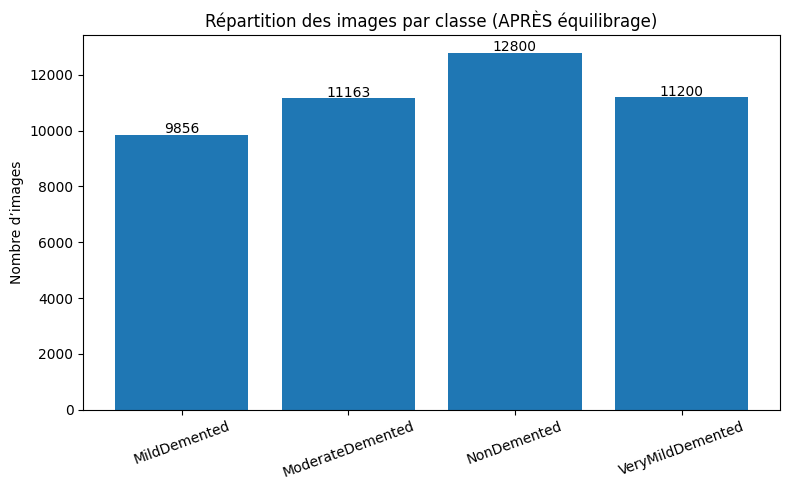

{'MildDemented': 9856,
 'ModerateDemented': 11163,
 'NonDemented': 12800,
 'VeryMildDemented': 11200}

In [42]:
import matplotlib.pyplot as plt

final_counts = {}

for class_name in os.listdir(DST_PATH):
    class_dir = os.path.join(DST_PATH, class_name)
    final_counts[class_name] = len(os.listdir(class_dir))

plt.figure(figsize=(8, 5))
plt.bar(final_counts.keys(), final_counts.values())
plt.ylabel("Nombre d’images")
plt.title("Répartition des images par classe (APRÈS équilibrage)")
plt.xticks(rotation=20)

for i, v in enumerate(final_counts.values()):
    plt.text(i, v + 50, str(v), ha="center")

plt.tight_layout()
plt.show()

final_counts


In [44]:
from PIL import Image

corrupted = []

for class_name in os.listdir(DATASET_PATH):
    class_dir = os.path.join(DATASET_PATH, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = Image.open(img_path)
            img.verify()
        except:
            corrupted.append(img_path)

print("Images corrompues :", len(corrupted))


Images corrompues : 0


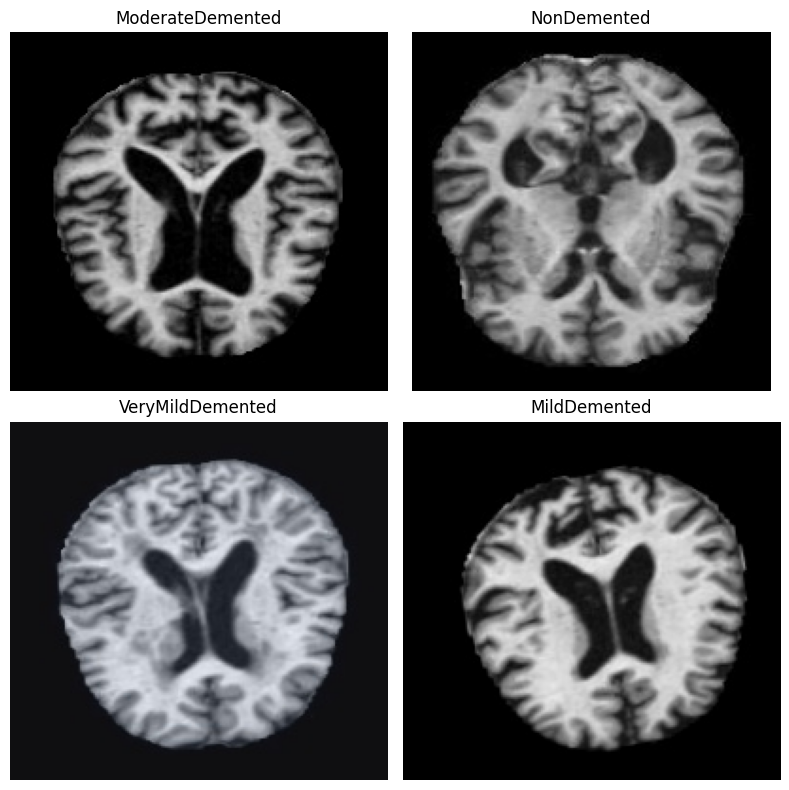

In [45]:
import random
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

for i, class_name in enumerate(os.listdir(DATASET_PATH)):
    class_dir = os.path.join(DATASET_PATH, class_name)
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)

    img = Image.open(img_path)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)


Found 32303 images belonging to 4 classes.
Found 8075 images belonging to 4 classes.


In [47]:
import os
import random
import shutil

# 🔹 Dataset déjà augmenté
DATASET_DIR = "/kaggle/working/dataset_augmented"

# 🔹 Dossier de sortie
BASE_DIR = "/kaggle/working/data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

# 🔹 Création des dossiers
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)

# 🔹 Classes
classes = sorted([
    d for d in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, d))
])

# 🔹 Ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1 

# 🔹 Split
for cls in classes:
    class_path = os.path.join(DATASET_DIR, cls)
    images = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    random.shuffle(images)

    n_total = len(images)
    n_train = int(TRAIN_RATIO * n_total)
    n_val = int(VAL_RATIO * n_total)

    splits = {
        TRAIN_DIR: images[:n_train],
        VAL_DIR: images[n_train:n_train + n_val],
        TEST_DIR: images[n_train + n_val:]
    }

    for split_dir, split_imgs in splits.items():
        cls_dir = os.path.join(split_dir, cls)
        os.makedirs(cls_dir, exist_ok=True)

        for img in split_imgs:
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(cls_dir, img)
            )

print("✅ Split train / val / test terminé")


✅ Split train / val / test terminé


In [48]:
for split in ["train", "val", "test"]:
    print(f"\n📁 {split.upper()}")
    for cls in classes:
        cls_dir = os.path.join(BASE_DIR, split, cls)
        print(cls, ":", len(os.listdir(cls_dir)))



📁 TRAIN
MildDemented : 7884
ModerateDemented : 8930
NonDemented : 10240
VeryMildDemented : 8960

📁 VAL
MildDemented : 985
ModerateDemented : 1116
NonDemented : 1280
VeryMildDemented : 1120

📁 TEST
MildDemented : 987
ModerateDemented : 1117
NonDemented : 1280
VeryMildDemented : 1120


In [51]:
import os, random, numpy as np
import tensorflow as tf

TRAIN_DIR = "/kaggle/working/data/train"
VAL_DIR   = "/kaggle/working/data/val"
TEST_DIR  = "/kaggle/working/data/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30  # tu peux augmenter après

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Train classes:", os.listdir(TRAIN_DIR))


Train classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

def make_gens(preprocess_fn):
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    val_datagen   = ImageDataGenerator(preprocessing_function=preprocess_fn)
    test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_fn)

    train_gen = train_datagen.flow_from_directory(
        TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode="categorical", shuffle=True, seed=SEED
    )
    val_gen = val_datagen.flow_from_directory(
        VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode="categorical", shuffle=False
    )
    test_gen = test_datagen.flow_from_directory(
        TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode="categorical", shuffle=False
    )
    return train_gen, val_gen, test_gen


In [53]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def build_transfer_model(base_model, num_classes):
    base_model.trainable = False  # on gèle le backbone (transfer learning)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.4)(x)
    out = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=out)
    model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def train_save_evaluate(model, model_name, train_gen, val_gen, test_gen):
    ckpt = ModelCheckpoint(
        filepath=f"{model_name}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1
    )
    es = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1)
    rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[ckpt, es, rlrop],
        verbose=1
    )

    # Charger le meilleur modèle sauvegardé (.h5)
    best_model = tf.keras.models.load_model(f"{model_name}.h5")

    test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)
    print(f"✅ {model_name} | Test accuracy = {test_acc:.4f}")

    return best_model, history


In [54]:
from tensorflow.keras.applications import VGG16

train_gen, val_gen, test_gen = make_gens(vgg_preprocess)
NUM_CLASSES = train_gen.num_classes
CLASS_NAMES = list(train_gen.class_indices.keys())

vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
vgg_model = build_transfer_model(vgg_base, NUM_CLASSES)

vgg_best, vgg_hist = train_save_evaluate(vgg_model, "vgg16_augmented", train_gen, val_gen, test_gen)


Found 36014 images belonging to 4 classes.
Found 4501 images belonging to 4 classes.
Found 4504 images belonging to 4 classes.


I0000 00:00:1766654235.814803      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766654235.815451      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1766654239.692592     291 service.cc:148] XLA service 0x798bb4006280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766654239.693598     291 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766654239.693617     291 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766654240.131415     291 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1126 ━━━━━━━━━━━━━━━━━━━━ 4:02:17 13s/step - accuracy: 0.1562 - loss: 6.5043

I0000 00:00:1766654251.037159     291 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4343 - loss: 1.9684
Epoch 1: val_accuracy improved from -inf to 0.67674, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 238s 200ms/step - accuracy: 0.4344 - loss: 1.9678 - val_accuracy: 0.6767 - val_loss: 0.7651 - learning_rate: 1.0000e-04
Epoch 2/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6378 - loss: 0.8232
Epoch 2: val_accuracy improved from 0.67674 to 0.71429, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.6378 - loss: 0.8232 - val_accuracy: 0.7143 - val_loss: 0.6684 - learning_rate: 1.0000e-04
Epoch 3/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6965 - loss: 0.6959
Epoch 3: val_accuracy improved from 0.71429 to 0.75894, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 216s 192ms/step - accuracy: 0.6965 - loss: 0.6959 - val_accuracy: 0.7589 - val_loss: 0.5882 - learning_rate: 1.0000e-04
Epoch 4/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7272 - loss: 0.6293
Epoch 4: val_accuracy improved from 0.75894 to 0.77338, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 216s 192ms/step - accuracy: 0.7272 - loss: 0.6293 - val_accuracy: 0.7734 - val_loss: 0.5436 - learning_rate: 1.0000e-04
Epoch 5/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7503 - loss: 0.5761
Epoch 5: val_accuracy improved from 0.77338 to 0.79560, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.7503 - loss: 0.5761 - val_accuracy: 0.7956 - val_loss: 0.5065 - learning_rate: 1.0000e-04
Epoch 6/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7690 - loss: 0.5378
Epoch 6: val_accuracy improved from 0.79560 to 0.80960, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 216s 192ms/step - accuracy: 0.7690 - loss: 0.5378 - val_accuracy: 0.8096 - val_loss: 0.4720 - learning_rate: 1.0000e-04
Epoch 7/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7951 - loss: 0.4895
Epoch 7: val_accuracy improved from 0.80960 to 0.82759, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.7951 - loss: 0.4895 - val_accuracy: 0.8276 - val_loss: 0.4319 - learning_rate: 1.0000e-04
Epoch 8/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8076 - loss: 0.4615
Epoch 8: val_accuracy improved from 0.82759 to 0.84292, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.8076 - loss: 0.4615 - val_accuracy: 0.8429 - val_loss: 0.4060 - learning_rate: 1.0000e-04
Epoch 9/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8170 - loss: 0.4378
Epoch 9: val_accuracy improved from 0.84292 to 0.85292, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.8170 - loss: 0.4378 - val_accuracy: 0.8529 - val_loss: 0.3860 - learning_rate: 1.0000e-04
Epoch 10/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8359 - loss: 0.4046
Epoch 10: val_accuracy improved from 0.85292 to 0.86092, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.8359 - loss: 0.4046 - val_accuracy: 0.8609 - val_loss: 0.3664 - learning_rate: 1.0000e-04
Epoch 11/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8455 - loss: 0.3835
Epoch 11: val_accuracy improved from 0.86092 to 0.86759, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.8455 - loss: 0.3835 - val_accuracy: 0.8676 - val_loss: 0.3369 - learning_rate: 1.0000e-04
Epoch 12/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8581 - loss: 0.3585
Epoch 12: val_accuracy improved from 0.86759 to 0.87869, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 216s 192ms/step - accuracy: 0.8581 - loss: 0.3585 - val_accuracy: 0.8787 - val_loss: 0.3223 - learning_rate: 1.0000e-04
Epoch 13/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8711 - loss: 0.3320
Epoch 13: val_accuracy did not improve from 0.87869
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.8710 - loss: 0.3320 - val_accuracy: 0.8776 - val_loss: 0.3131 - learning_rate: 1.0000e-04
Epoch 14/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8709 - loss: 0.3226
Epoch 14: val_accuracy improved from 0.87869 to 0.88669, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.8709 - loss: 0.3226 - val_accuracy: 0.8867 - val_loss: 0.2932 - learning_rate: 1.0000e-04
Epoch 15/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8808 - loss: 0.3052
Epoch 15: val_accuracy improved from 0.88669 to 0.89802, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.8808 - loss: 0.3052 - val_accuracy: 0.8980 - val_loss: 0.2797 - learning_rate: 1.0000e-04
Epoch 16/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8864 - loss: 0.2857
Epoch 16: val_accuracy improved from 0.89802 to 0.90002, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.8864 - loss: 0.2857 - val_accuracy: 0.9000 - val_loss: 0.2660 - learning_rate: 1.0000e-04
Epoch 17/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8959 - loss: 0.2756
Epoch 17: val_accuracy improved from 0.90002 to 0.90136, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.8959 - loss: 0.2756 - val_accuracy: 0.9014 - val_loss: 0.2558 - learning_rate: 1.0000e-04
Epoch 18/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9000 - loss: 0.2590
Epoch 18: val_accuracy improved from 0.90136 to 0.90691, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.9000 - loss: 0.2590 - val_accuracy: 0.9069 - val_loss: 0.2415 - learning_rate: 1.0000e-04
Epoch 19/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9074 - loss: 0.2427
Epoch 19: val_accuracy improved from 0.90691 to 0.91202, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.9074 - loss: 0.2427 - val_accuracy: 0.9120 - val_loss: 0.2323 - learning_rate: 1.0000e-04
Epoch 20/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9096 - loss: 0.2404
Epoch 20: val_accuracy did not improve from 0.91202
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.9096 - loss: 0.2404 - val_accuracy: 0.9120 - val_loss: 0.2263 - learning_rate: 1.0000e-04
Epoch 21/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9128 - loss: 0.2292
Epoch 21: val_accuracy improved from 0.91202 to 0.91646, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.9128 - loss: 0.2292 - val_accuracy: 0.9165 - val_loss: 0.2155 - learning_rate: 1.0000e-04
Epoch 22/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9196 - loss: 0.2131
Epoch 22: val_accuracy improved from 0.91646 to 0.92091, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.9196 - loss: 0.2131 - val_accuracy: 0.9209 - val_loss: 0.2210 - learning_rate: 1.0000e-04
Epoch 23/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9229 - loss: 0.2097
Epoch 23: val_accuracy improved from 0.92091 to 0.92735, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.9229 - loss: 0.2097 - val_accuracy: 0.9273 - val_loss: 0.2006 - learning_rate: 1.0000e-04
Epoch 24/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9283 - loss: 0.1980
Epoch 24: val_accuracy did not improve from 0.92735
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 216s 191ms/step - accuracy: 0.9283 - loss: 0.1980 - val_accuracy: 0.9236 - val_loss: 0.1984 - learning_rate: 1.0000e-04
Epoch 25/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9317 - loss: 0.1877
Epoch 25: val_accuracy improved from 0.92735 to 0.93157, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.9317 - loss: 0.1877 - val_accuracy: 0.9316 - val_loss: 0.1922 - learning_rate: 1.0000e-04
Epoch 26/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9355 - loss: 0.1770
Epoch 26: val_accuracy improved from 0.93157 to 0.93557, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.9355 - loss: 0.1770 - val_accuracy: 0.9356 - val_loss: 0.1840 - learning_rate: 1.0000e-04
Epoch 27/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9349 - loss: 0.1743
Epoch 27: val_accuracy did not improve from 0.93557
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.9349 - loss: 0.1743 - val_accuracy: 0.9325 - val_loss: 0.1853 - learning_rate: 1.0000e-04
Epoch 28/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9393 - loss: 0.1667
Epoch 28: val_accuracy did not improve from 0.93557
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.9393 - loss: 0.1667 - val_accuracy: 0.9356 - val_loss: 0.1697 - learning_rate: 1.0000e-04
Epoch 29/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9409 - loss: 0.1619
Epoch 29: val_accuracy improved from 0.93557 to 0.93779, saving model to vgg16_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 216s 192ms/step - accuracy: 0.9409 - loss: 0.1619 - val_accuracy: 0.9378 - val_loss: 0.1677 - learning_rate: 1.0000e-04
Epoch 30/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9424 - loss: 0.1582
Epoch 30: val_accuracy did not improve from 0.93779
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 215s 191ms/step - accuracy: 0.9424 - loss: 0.1582 - val_accuracy: 0.9349 - val_loss: 0.1732 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 29.


141/141 ━━━━━━━━━━━━━━━━━━━━ 33s 231ms/step - accuracy: 0.9494 - loss: 0.1361
✅ vgg16_augmented | Test accuracy = 0.9367


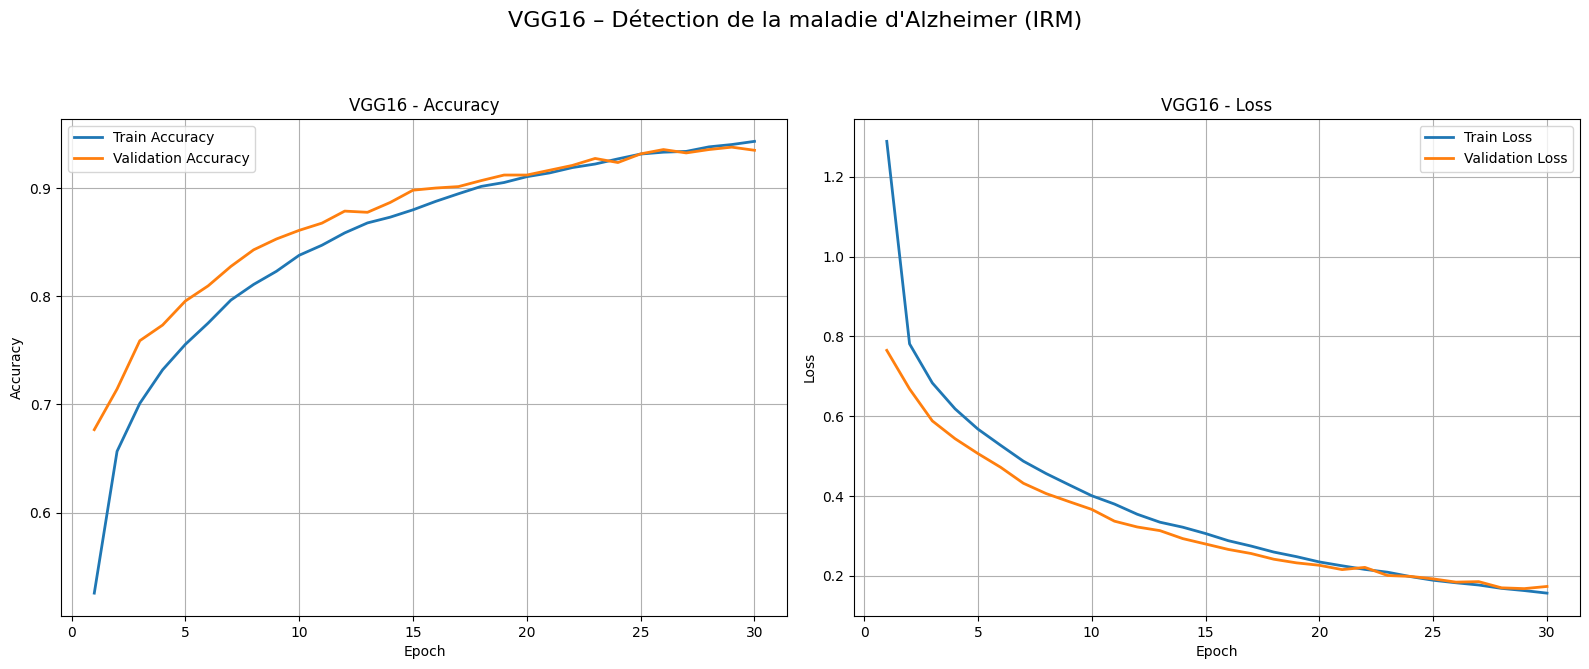

In [55]:
import matplotlib.pyplot as plt

H = vgg_hist.history
epochs = range(1, len(H['loss']) + 1)

plt.figure(figsize=(16, 12))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, H['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(epochs, H['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('VGG16 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, H['loss'], label='Train Loss', linewidth=2)
plt.plot(epochs, H['val_loss'], label='Validation Loss', linewidth=2)
plt.title('VGG16 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle("VGG16 – Détection de la maladie d'Alzheimer (IRM)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step


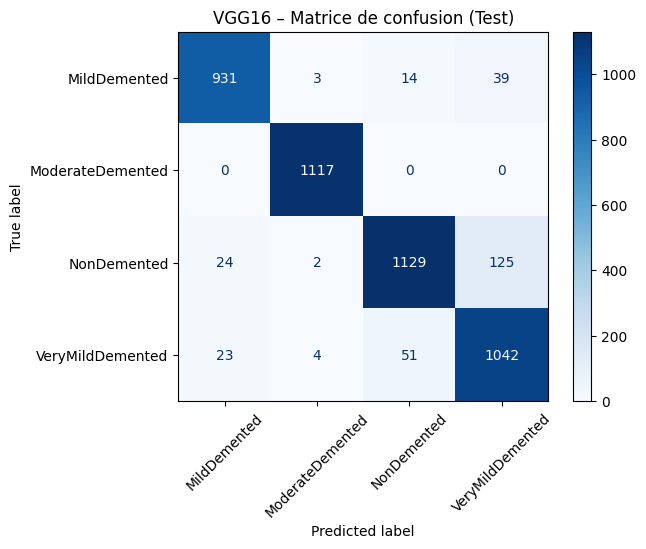

In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédictions sur le test set
y_true = test_gen.classes
y_pred = np.argmax(vgg_best.predict(test_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("VGG16 – Matrice de confusion (Test)")
plt.show()


In [57]:
from tensorflow.keras.applications import ResNet50

train_gen, val_gen, test_gen = make_gens(resnet_preprocess)

resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
resnet_model = build_transfer_model(resnet_base, NUM_CLASSES)

resnet_best, resnet_hist = train_save_evaluate(
    resnet_model, "resnet50_augmented",
    train_gen, val_gen, test_gen
)


Found 36014 images belonging to 4 classes.
Found 4501 images belonging to 4 classes.
Found 4504 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5260 - loss: 1.1119
Epoch 1: val_accuracy improved from -inf to 0.68185, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 132s 106ms/step - accuracy: 0.5260 - loss: 1.1117 - val_accuracy: 0.6818 - val_loss: 0.7364 - learning_rate: 1.0000e-04
Epoch 2/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6767 - loss: 0.7346
Epoch 2: val_accuracy improved from 0.68185 to 0.70940, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.6767 - loss: 0.7346 - val_accuracy: 0.7094 - val_loss: 0.6540 - learning_rate: 1.0000e-04
Epoch 3/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7124 - loss: 0.6533
Epoch 3: val_accuracy improved from 0.70940 to 0.74317, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.7124 - loss: 0.6533 - val_accuracy: 0.7432 - val_loss: 0.5987 - learning_rate: 1.0000e-04
Epoch 4/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7366 - loss: 0.6030
Epoch 4: val_accuracy improved from 0.74317 to 0.75983, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.7366 - loss: 0.6030 - val_accuracy: 0.7598 - val_loss: 0.5611 - learning_rate: 1.0000e-04
Epoch 5/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7584 - loss: 0.5595
Epoch 5: val_accuracy improved from 0.75983 to 0.77649, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.7584 - loss: 0.5595 - val_accuracy: 0.7765 - val_loss: 0.5348 - learning_rate: 1.0000e-04
Epoch 6/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7747 - loss: 0.5293
Epoch 6: val_accuracy improved from 0.77649 to 0.79582, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.7747 - loss: 0.5293 - val_accuracy: 0.7958 - val_loss: 0.4982 - learning_rate: 1.0000e-04
Epoch 7/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7903 - loss: 0.4971
Epoch 7: val_accuracy did not improve from 0.79582
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.7903 - loss: 0.4971 - val_accuracy: 0.7954 - val_loss: 0.4873 - learning_rate: 1.0000e-04
Epoch 8/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8001 - loss: 0.4736
Epoch 8: val_accuracy improved from 0.79582 to 0.79871, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8001 - loss: 0.4736 - val_accuracy: 0.7987 - val_loss: 0.4771 - learning_rate: 1.0000e-04
Epoch 9/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8089 - loss: 0.4516
Epoch 9: val_accuracy improved from 0.79871 to 0.82382, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.8089 - loss: 0.4516 - val_accuracy: 0.8238 - val_loss: 0.4423 - learning_rate: 1.0000e-04
Epoch 10/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8238 - loss: 0.4257
Epoch 10: val_accuracy improved from 0.82382 to 0.83670, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.8238 - loss: 0.4256 - val_accuracy: 0.8367 - val_loss: 0.4221 - learning_rate: 1.0000e-04
Epoch 11/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8367 - loss: 0.4028
Epoch 11: val_accuracy improved from 0.83670 to 0.85026, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8367 - loss: 0.4028 - val_accuracy: 0.8503 - val_loss: 0.3926 - learning_rate: 1.0000e-04
Epoch 12/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8409 - loss: 0.3940
Epoch 12: val_accuracy improved from 0.85026 to 0.85359, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.8409 - loss: 0.3940 - val_accuracy: 0.8536 - val_loss: 0.3849 - learning_rate: 1.0000e-04
Epoch 13/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8537 - loss: 0.3716
Epoch 13: val_accuracy improved from 0.85359 to 0.86447, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.8537 - loss: 0.3716 - val_accuracy: 0.8645 - val_loss: 0.3702 - learning_rate: 1.0000e-04
Epoch 14/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8602 - loss: 0.3559
Epoch 14: val_accuracy did not improve from 0.86447
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8602 - loss: 0.3559 - val_accuracy: 0.8603 - val_loss: 0.3602 - learning_rate: 1.0000e-04
Epoch 15/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8679 - loss: 0.3389
Epoch 15: val_accuracy improved from 0.86447 to 0.87292, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8679 - loss: 0.3388 - val_accuracy: 0.8729 - val_loss: 0.3418 - learning_rate: 1.0000e-04
Epoch 16/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8714 - loss: 0.3239
Epoch 16: val_accuracy did not improve from 0.87292
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8714 - loss: 0.3239 - val_accuracy: 0.8674 - val_loss: 0.3426 - learning_rate: 1.0000e-04
Epoch 17/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8808 - loss: 0.3128
Epoch 17: val_accuracy improved from 0.87292 to 0.87381, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.8808 - loss: 0.3128 - val_accuracy: 0.8738 - val_loss: 0.3283 - learning_rate: 1.0000e-04
Epoch 18/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8860 - loss: 0.2987
Epoch 18: val_accuracy improved from 0.87381 to 0.88114, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.8860 - loss: 0.2987 - val_accuracy: 0.8811 - val_loss: 0.3168 - learning_rate: 1.0000e-04
Epoch 19/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8930 - loss: 0.2829
Epoch 19: val_accuracy improved from 0.88114 to 0.88603, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8930 - loss: 0.2829 - val_accuracy: 0.8860 - val_loss: 0.3041 - learning_rate: 1.0000e-04
Epoch 20/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8950 - loss: 0.2730
Epoch 20: val_accuracy improved from 0.88603 to 0.89758, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.8950 - loss: 0.2729 - val_accuracy: 0.8976 - val_loss: 0.2843 - learning_rate: 1.0000e-04
Epoch 21/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9015 - loss: 0.2588
Epoch 21: val_accuracy did not improve from 0.89758
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.9015 - loss: 0.2588 - val_accuracy: 0.8922 - val_loss: 0.2892 - learning_rate: 1.0000e-04
Epoch 22/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9074 - loss: 0.2470
Epoch 22: val_accuracy improved from 0.89758 to 0.89780, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.9074 - loss: 0.2470 - val_accuracy: 0.8978 - val_loss: 0.2780 - learning_rate: 1.0000e-04
Epoch 23/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9071 - loss: 0.2438
Epoch 23: val_accuracy improved from 0.89780 to 0.90558, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.9071 - loss: 0.2438 - val_accuracy: 0.9056 - val_loss: 0.2648 - learning_rate: 1.0000e-04
Epoch 24/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9155 - loss: 0.2282
Epoch 24: val_accuracy did not improve from 0.90558
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.9155 - loss: 0.2282 - val_accuracy: 0.8936 - val_loss: 0.2833 - learning_rate: 1.0000e-04
Epoch 25/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9175 - loss: 0.2268
Epoch 25: val_accuracy did not improve from 0.90558
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.9175 - loss: 0.2268 - val_accuracy: 0.9051 - val_loss: 0.2580 - learning_rate: 1.0000e-04
Epoch 26/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9229 - loss: 0.2120
Epoch 26: val_accuracy improved from 0.90558 to 0.91024, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.9229 - loss: 0.2120 - val_accuracy: 0.9102 - val_loss: 0.2442 - learning_rate: 1.0000e-04
Epoch 27/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9246 - loss: 0.2056
Epoch 27: val_accuracy improved from 0.91024 to 0.91202, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.9246 - loss: 0.2056 - val_accuracy: 0.9120 - val_loss: 0.2409 - learning_rate: 1.0000e-04
Epoch 28/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9279 - loss: 0.1987
Epoch 28: val_accuracy did not improve from 0.91202
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.9279 - loss: 0.1987 - val_accuracy: 0.9120 - val_loss: 0.2374 - learning_rate: 1.0000e-04
Epoch 29/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9262 - loss: 0.1984
Epoch 29: val_accuracy did not improve from 0.91202
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 106s 94ms/step - accuracy: 0.9262 - loss: 0.1984 - val_accuracy: 0.9105 - val_loss: 0.2403 - learning_rate: 1.0000e-04
Epoch 30/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9331 - loss: 0.1840
Epoch 30: val_accuracy improved from 0.91202 to 0.92002, saving model to resnet50_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 107s 95ms/step - accuracy: 0.9331 - loss: 0.1840 - val_accuracy: 0.9200 - val_loss: 0.2272 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.


141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9521 - loss: 0.1404
✅ resnet50_augmented | Test accuracy = 0.9147


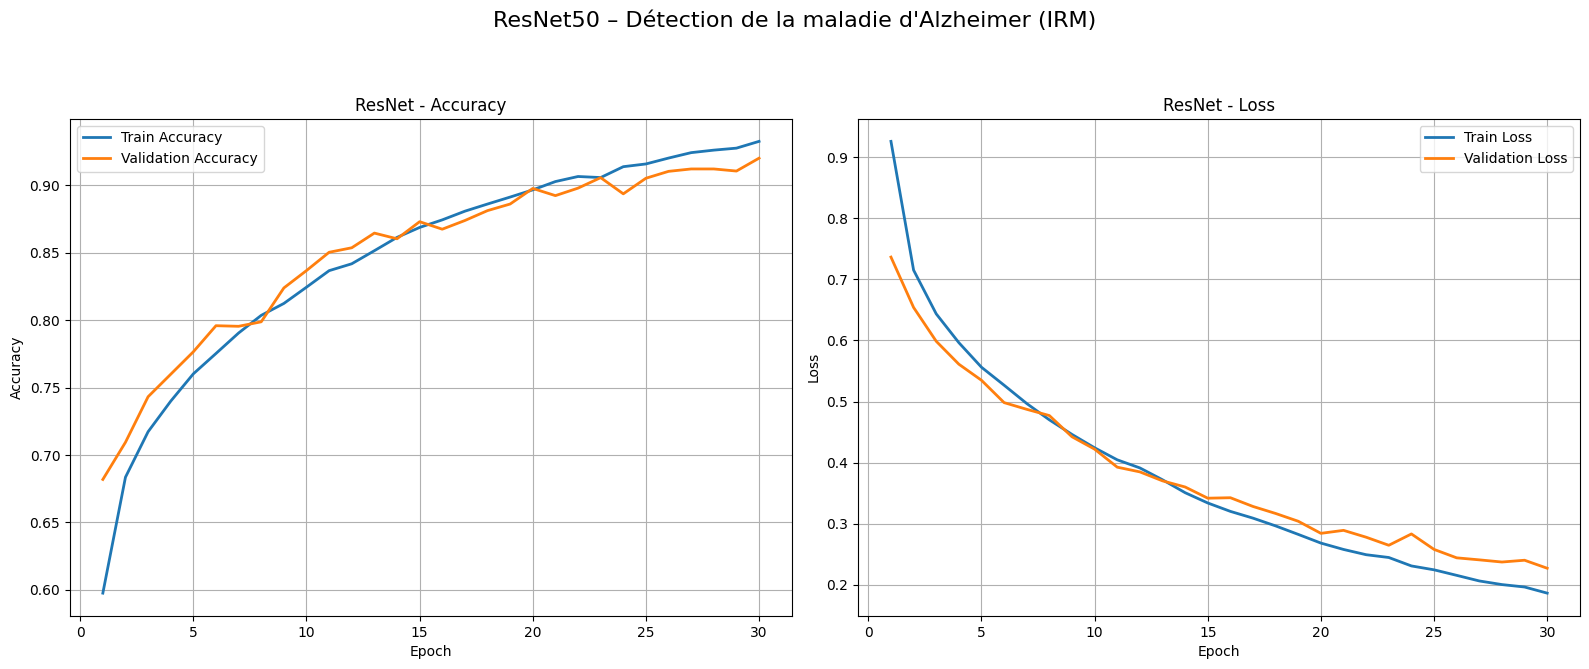

In [58]:
H = resnet_hist.history
epochs = range(1, len(H['loss']) + 1)

plt.figure(figsize=(16, 12))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, H['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(epochs, H['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('ResNet - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, H['loss'], label='Train Loss', linewidth=2)
plt.plot(epochs, H['val_loss'], label='Validation Loss', linewidth=2)
plt.title('ResNet - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle("ResNet50 – Détection de la maladie d'Alzheimer (IRM)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step


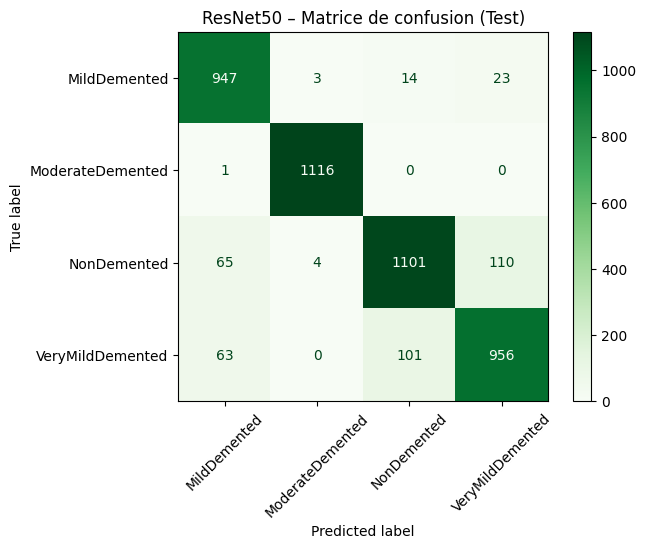

In [59]:
y_pred = np.argmax(resnet_best.predict(test_gen), axis=1)
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap="Greens", xticks_rotation=45)
plt.title("ResNet50 – Matrice de confusion (Test)")
plt.show()


In [60]:
from tensorflow.keras.applications import EfficientNetB0

train_gen, val_gen, test_gen = make_gens(eff_preprocess)

eff_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
eff_model = build_transfer_model(eff_base, NUM_CLASSES)

eff_best, eff_hist = train_save_evaluate(
    eff_model, "efficientnetb0_augmented",
    train_gen, val_gen, test_gen
)


Found 36014 images belonging to 4 classes.
Found 4501 images belonging to 4 classes.
Found 4504 images belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4796 - loss: 1.1391
Epoch 1: val_accuracy improved from -inf to 0.64630, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 89s 60ms/step - accuracy: 0.4797 - loss: 1.1390 - val_accuracy: 0.6463 - val_loss: 0.8054 - learning_rate: 1.0000e-04
Epoch 2/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6272 - loss: 0.8463
Epoch 2: val_accuracy improved from 0.64630 to 0.67563, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.6272 - loss: 0.8463 - val_accuracy: 0.6756 - val_loss: 0.7216 - learning_rate: 1.0000e-04
Epoch 3/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6658 - loss: 0.7635
Epoch 3: val_accuracy improved from 0.67563 to 0.71140, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.6658 - loss: 0.7635 - val_accuracy: 0.7114 - val_loss: 0.6646 - learning_rate: 1.0000e-04
Epoch 4/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6821 - loss: 0.7161
Epoch 4: val_accuracy improved from 0.71140 to 0.72495, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.6821 - loss: 0.7161 - val_accuracy: 0.7250 - val_loss: 0.6325 - learning_rate: 1.0000e-04
Epoch 5/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7015 - loss: 0.6761
Epoch 5: val_accuracy improved from 0.72495 to 0.74717, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.7015 - loss: 0.6761 - val_accuracy: 0.7472 - val_loss: 0.6150 - learning_rate: 1.0000e-04
Epoch 6/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7179 - loss: 0.6497
Epoch 6: val_accuracy did not improve from 0.74717
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - accuracy: 0.7179 - loss: 0.6497 - val_accuracy: 0.7454 - val_loss: 0.5809 - learning_rate: 1.0000e-04
Epoch 7/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7235 - loss: 0.6258
Epoch 7: val_accuracy improved from 0.74717 to 0.75650, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.7235 - loss: 0.6258 - val_accuracy: 0.7565 - val_loss: 0.5640 - learning_rate: 1.0000e-04
Epoch 8/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7386 - loss: 0.6069
Epoch 8: val_accuracy improved from 0.75650 to 0.77116, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.7386 - loss: 0.6069 - val_accuracy: 0.7712 - val_loss: 0.5449 - learning_rate: 1.0000e-04
Epoch 9/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7420 - loss: 0.5926
Epoch 9: val_accuracy improved from 0.77116 to 0.78205, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.7420 - loss: 0.5925 - val_accuracy: 0.7820 - val_loss: 0.5241 - learning_rate: 1.0000e-04
Epoch 10/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7511 - loss: 0.5807
Epoch 10: val_accuracy did not improve from 0.78205
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - accuracy: 0.7511 - loss: 0.5807 - val_accuracy: 0.7800 - val_loss: 0.5125 - learning_rate: 1.0000e-04
Epoch 11/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7610 - loss: 0.5590
Epoch 11: val_accuracy improved from 0.78205 to 0.78538, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.7610 - loss: 0.5590 - val_accuracy: 0.7854 - val_loss: 0.4991 - learning_rate: 1.0000e-04
Epoch 12/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7677 - loss: 0.5442
Epoch 12: val_accuracy improved from 0.78538 to 0.79027, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.7677 - loss: 0.5442 - val_accuracy: 0.7903 - val_loss: 0.4911 - learning_rate: 1.0000e-04
Epoch 13/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7724 - loss: 0.5343
Epoch 13: val_accuracy improved from 0.79027 to 0.79871, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.7724 - loss: 0.5343 - val_accuracy: 0.7987 - val_loss: 0.4716 - learning_rate: 1.0000e-04
Epoch 14/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7888 - loss: 0.5105
Epoch 14: val_accuracy improved from 0.79871 to 0.80760, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.7888 - loss: 0.5105 - val_accuracy: 0.8076 - val_loss: 0.4566 - learning_rate: 1.0000e-04
Epoch 15/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7890 - loss: 0.5026
Epoch 15: val_accuracy improved from 0.80760 to 0.82271, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.7890 - loss: 0.5026 - val_accuracy: 0.8227 - val_loss: 0.4428 - learning_rate: 1.0000e-04
Epoch 16/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7933 - loss: 0.4922
Epoch 16: val_accuracy did not improve from 0.82271
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - accuracy: 0.7933 - loss: 0.4922 - val_accuracy: 0.8183 - val_loss: 0.4369 - learning_rate: 1.0000e-04
Epoch 17/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8031 - loss: 0.4776
Epoch 17: val_accuracy improved from 0.82271 to 0.83159, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.8031 - loss: 0.4776 - val_accuracy: 0.8316 - val_loss: 0.4196 - learning_rate: 1.0000e-04
Epoch 18/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8061 - loss: 0.4700
Epoch 18: val_accuracy improved from 0.83159 to 0.83537, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.8061 - loss: 0.4700 - val_accuracy: 0.8354 - val_loss: 0.4126 - learning_rate: 1.0000e-04
Epoch 19/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8130 - loss: 0.4539
Epoch 19: val_accuracy did not improve from 0.83537
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.8130 - loss: 0.4539 - val_accuracy: 0.8311 - val_loss: 0.4052 - learning_rate: 1.0000e-04
Epoch 20/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8172 - loss: 0.4461
Epoch 20: val_accuracy improved from 0.83537 to 0.84337, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.8172 - loss: 0.4461 - val_accuracy: 0.8434 - val_loss: 0.3922 - learning_rate: 1.0000e-04
Epoch 21/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8231 - loss: 0.4332
Epoch 21: val_accuracy improved from 0.84337 to 0.84470, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.8231 - loss: 0.4332 - val_accuracy: 0.8447 - val_loss: 0.3818 - learning_rate: 1.0000e-04
Epoch 22/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8258 - loss: 0.4259
Epoch 22: val_accuracy improved from 0.84470 to 0.85425, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.8258 - loss: 0.4259 - val_accuracy: 0.8543 - val_loss: 0.3704 - learning_rate: 1.0000e-04
Epoch 23/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8298 - loss: 0.4185
Epoch 23: val_accuracy improved from 0.85425 to 0.85892, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - accuracy: 0.8298 - loss: 0.4185 - val_accuracy: 0.8589 - val_loss: 0.3625 - learning_rate: 1.0000e-04
Epoch 24/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8350 - loss: 0.4076
Epoch 24: val_accuracy improved from 0.85892 to 0.86292, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.8350 - loss: 0.4076 - val_accuracy: 0.8629 - val_loss: 0.3579 - learning_rate: 1.0000e-04
Epoch 25/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8399 - loss: 0.3980
Epoch 25: val_accuracy improved from 0.86292 to 0.86803, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.8399 - loss: 0.3980 - val_accuracy: 0.8680 - val_loss: 0.3459 - learning_rate: 1.0000e-04
Epoch 26/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8422 - loss: 0.3938
Epoch 26: val_accuracy did not improve from 0.86803
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.8422 - loss: 0.3938 - val_accuracy: 0.8667 - val_loss: 0.3381 - learning_rate: 1.0000e-04
Epoch 27/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8400 - loss: 0.3953
Epoch 27: val_accuracy improved from 0.86803 to 0.87447, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - accuracy: 0.8400 - loss: 0.3953 - val_accuracy: 0.8745 - val_loss: 0.3294 - learning_rate: 1.0000e-04
Epoch 28/30
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8508 - loss: 0.3773
Epoch 28: val_accuracy did not improve from 0.87447
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.8508 - loss: 0.3773 - val_accuracy: 0.8689 - val_loss: 0.3307 - learning_rate: 1.0000e-04
Epoch 29/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8496 - loss: 0.3766
Epoch 29: val_accuracy improved from 0.87447 to 0.87625, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - accuracy: 0.8496 - loss: 0.3766 - val_accuracy: 0.8762 - val_loss: 0.3209 - learning_rate: 1.0000e-04
Epoch 30/30
1125/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8550 - loss: 0.3669
Epoch 30: val_accuracy improved from 0.87625 to 0.88180, saving model to efficientnetb0_augmented.h5


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - accuracy: 0.8550 - loss: 0.3669 - val_accuracy: 0.8818 - val_loss: 0.3147 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 30.


141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.9378 - loss: 0.2156
✅ efficientnetb0_augmented | Test accuracy = 0.8865


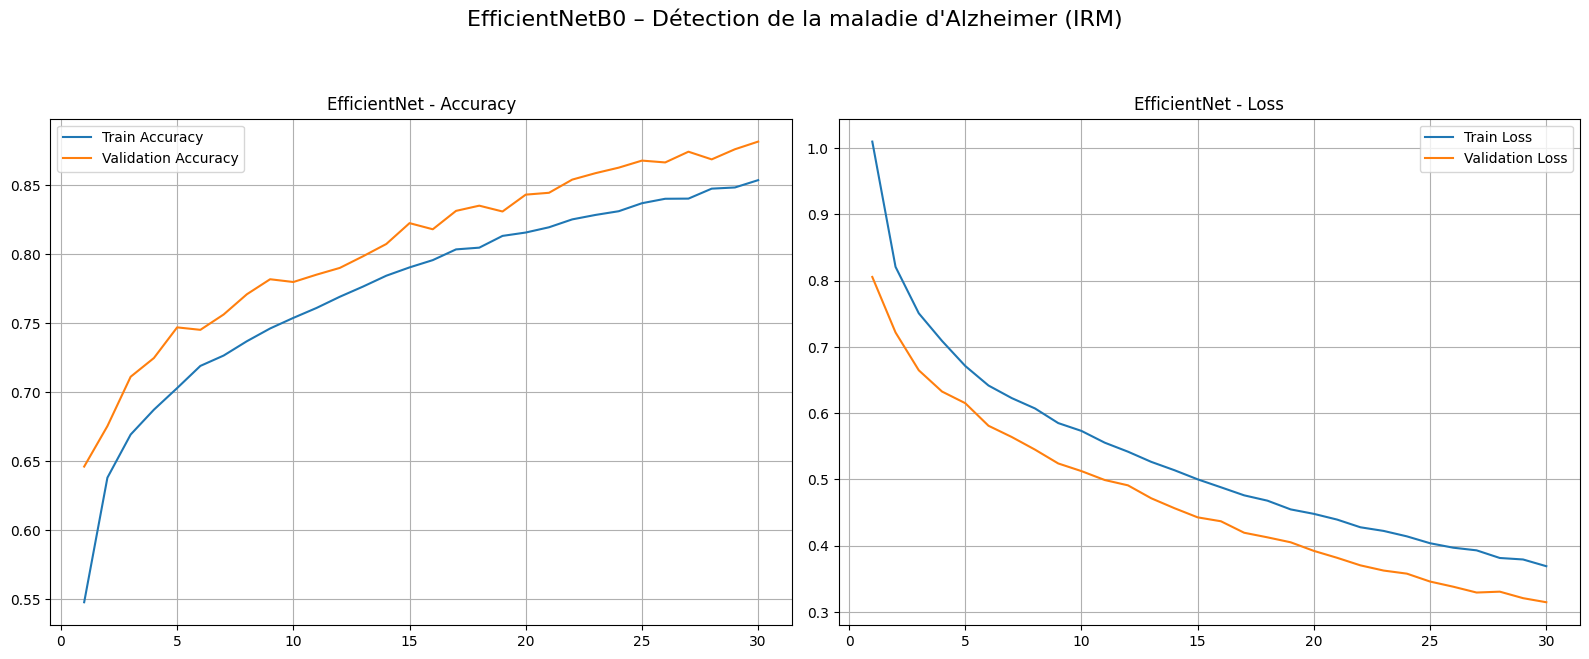

In [61]:
H = eff_hist.history
epochs = range(1, len(H['loss']) + 1)

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.plot(epochs, H['accuracy'], label='Train Accuracy')
plt.plot(epochs, H['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNet - Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, H['loss'], label='Train Loss')
plt.plot(epochs, H['val_loss'], label='Validation Loss')
plt.title('EfficientNet - Loss')
plt.legend()
plt.grid(True)

plt.suptitle("EfficientNetB0 – Détection de la maladie d'Alzheimer (IRM)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


141/141 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step


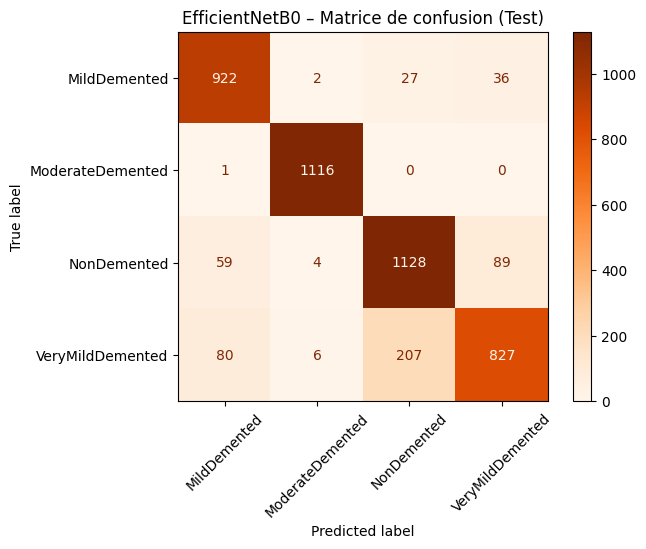

In [62]:
y_pred = np.argmax(eff_best.predict(test_gen), axis=1)
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap="Oranges", xticks_rotation=45)
plt.title("EfficientNetB0 – Matrice de confusion (Test)")
plt.show()


In [63]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import random
import os


In [64]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), class_idx.numpy()


In [65]:
def show_gradcam(img_path, model, last_conv_layer, preprocess_fn, model_name):
    # Charger image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_fn(img_array)

    # Grad-CAM
    heatmap, pred_class = make_gradcam_heatmap(
        img_array, model, last_conv_layer
    )

    # Image originale
    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (224, 224))

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.title(f"{model_name} | Prédit : {CLASS_NAMES[pred_class]}")
    plt.axis("off")
    plt.show()


In [66]:
# Choisir une classe au hasard
chosen_class = random.choice(CLASS_NAMES)
test_class_dir = os.path.join(TEST_DIR, chosen_class)

img_name = random.choice(os.listdir(test_class_dir))
img_path = os.path.join(test_class_dir, img_name)

print("Classe réelle :", chosen_class)
print("Image :", img_path)


Classe réelle : MildDemented
Image : /kaggle/working/data/test/MildDemented/30 (11).jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


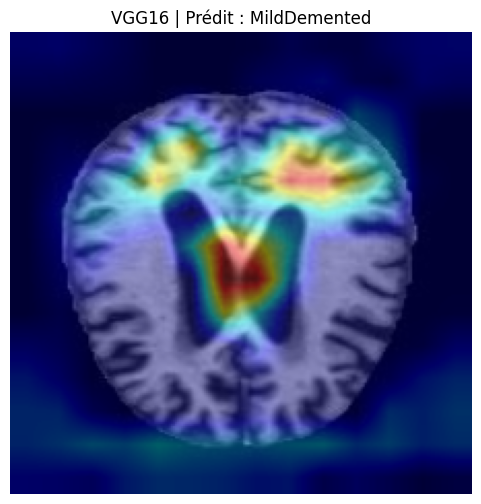

In [67]:
show_gradcam(
    img_path,
    vgg_best,
    last_conv_layer="block5_conv3",
    preprocess_fn=vgg_preprocess,
    model_name="VGG16"
)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


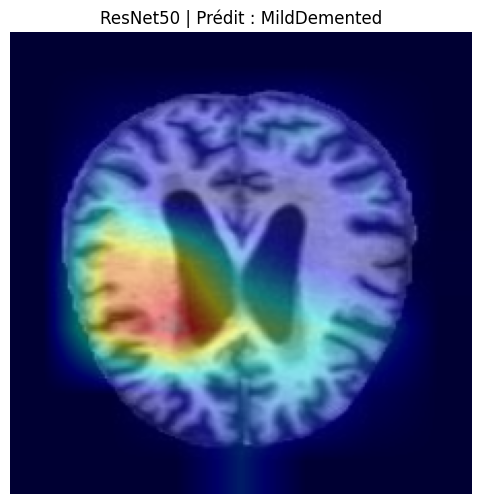

In [68]:
show_gradcam(
    img_path,
    resnet_best,
    last_conv_layer="conv5_block3_out",
    preprocess_fn=resnet_preprocess,
    model_name="ResNet50"
)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_2']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


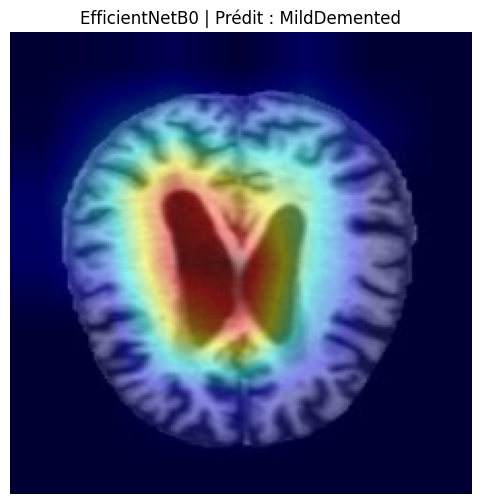

In [69]:
show_gradcam(
    img_path,
    eff_best,
    last_conv_layer="top_conv",
    preprocess_fn=eff_preprocess,
    model_name="EfficientNetB0"
)
